# Food Recognition System For Passio
## By: Sarah Hernandez



In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
import cv2
import math
from random import shuffleS
import matplotlib.pyplot as plt
import skimage
    


### Goal 1: Prepare a Dataset:

#### Step 1: Explore Dataset


Foods: 144
Not Foods: 125
Example Food Shape: (640, 640, 3)
Example Not Food Shape: (4032, 3024, 3)
Example Food Shape: (480, 640, 3)
Example Not Food Shape: (3024, 4032, 3)
Example Food Shape: (612, 612, 3)
Example Not Food Shape: (640, 360, 3)


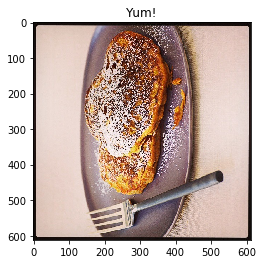

In [3]:
currentDir = "/Users/sarahhernandez/Documents/4. Important Docs/Passio/passio-ml-coding-challenge"
foodDir = "/Users/sarahhernandez/Documents/4. Important Docs/Passio/passio-ml-coding-challenge/Food"
notFoodDir = "/Users/sarahhernandez/Documents/4. Important Docs/Passio/passio-ml-coding-challenge/NotFood"

foodList = os.listdir(foodDir)
numFoods = 144 #len(foodList), entered original length before data augmentation

notFoodList = os.listdir(notFoodDir)
numNotFoods = 125 #len(notFoodList), entered original length before data augmentation

print("Foods: " + str(numFoods))
print("Not Foods: " + str(numNotFoods))

for i in range(3):
    testDir = foodDir + "/" + foodList[i]
    img = cv2.imread(testDir)
    print("Example Food Shape: " + str(img.shape))
    testDir2 = notFoodDir + "/" + notFoodList[i]
    img2 = cv2.imread(testDir2)
    print("Example Not Food Shape: " + str(img2.shape))
    


#Matplot lib expects img in RGB format but OpenCV provides it in BGR.
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.title("Yum!")
plt.show()


So we have fewer than 300 images of food and not food, of various square and rectangular sizes. This is a rather small data set, so we'll augment the data using a few tricks:


#### Step 2: Augment Data

In [60]:
# Get array of directories of food and not food
def get_image_dirs(foodList, notFoodList):
    
    foodDirs = []
    for food in foodList:
        if not food.startswith('.'):
            foodDirs.append(foodDir + "/" + food)
    
    notFoodDirs = []
    for notFood in notFoodList:
        if not notFood.startswith('.'):
            notFoodDirs.append(notFoodDir + "/" + notFood)
        
    
    return foodDirs, notFoodDirs
        

foodDirs, notFoodDirs = get_image_dirs(foodList, notFoodList)



In [332]:

# First trick: flip and rotate images
for i in range(numFoods):
    img = cv2.imread(foodDirs[i])
    img2 = np.fliplr(img)
    img3 = np.flipud(img)
    img4 = np.rot90(img)
    cv2.imwrite(foodDir + "/lr" + str(i) + ".jpg", img2)
    cv2.imwrite(foodDir + "/ud" + str(i) + ".jpg", img3)
    cv2.imwrite(foodDir + "/rot90" + str(i) + ".jpg", img4)
    
for i in range(numNotFoods):
    img = cv2.imread(notFoodDirs[i])
    img2 = np.fliplr(img)
    img3 = np.flipud(img)
    img4 = np.rot90(img)
    cv2.imwrite(notFoodDir + "/lr" + str(i) + ".jpg", img2)
    cv2.imwrite(notFoodDir + "/ud" + str(i) + ".jpg", img3)
    cv2.imwrite(notFoodDir + "/rot90" + str(i) + ".jpg", img4)
    
print("Completed")


Completed


In [321]:
# Update Food and NotFood Dirs:
foodList = os.listdir(foodDir)

notFoodList = os.listdir(notFoodDir)

foodDirs, notFoodDirs = get_image_dirs(foodList, notFoodList)

print("Directories created")
    


Directories created


In [441]:
# Second trick: add noise to images:
for i in range(len(foodDirs)):
    
    img = cv2.imread(foodDirs[i])
    img = cv2.resize(img,(256,256))
    row,col,ch= img.shape
    mean = 0
    gauss = np.random.normal(mean,30,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img + gauss
    cv2.imwrite(foodDir + "/noisy" + str(i) + ".jpg", noisy)


print("Noisy Food Created")

for i in range(len(notFoodDirs)):
    
    img = cv2.imread(notFoodDirs[i])
    img = cv2.resize(img,(256,256))
    row,col,ch= img.shape
    mean = math.ceil(255/2)
    gauss = np.random.normal(mean,50,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img + gauss
    cv2.imwrite(notFoodDir + "/noisy" + str(i) + ".jpg", noisy)
       
print("Noisy Not Food Created")


Noisy Food Created
Noisy Not Food Created


In [442]:
foodList = os.listdir(foodDir)

notFoodList = os.listdir(notFoodDir)

foodDirs, notFoodDirs = get_image_dirs(foodList, notFoodList)

print("Number of Foods: " + str(len(foodDirs)))
print("Number of Not Foods: " + str(len(notFoodDirs)))


Number of Foods: 1152
Number of Not Foods: 1000


Now we've got something to work with! Next, let's generate the dataset:

#### Step 3: Generate Dataset

In [443]:
import cv2
class Generate_Dataset:
    
    def __init__(self, data_dirs):
        self.data_dirs = data_dirs
        self.labels = []
        self.data_paths = []
        self.images = []
        
        # Now we put all data paths in a single matrix and shuffle it: 
        self.data_paths = np.concatenate([self.data_dirs[0], self.data_dirs[1]])
        shuffle(self.data_paths)
        
        #Next, generate labels:
        for path in self.data_paths:
            self.labels.append(self.generate_data_labels(path))
            self.images.append(self.get_image(path))
        
        
    # Returns label of specified file
    def generate_data_labels(self, directory):
        labels = []
        # Because we're doing a simple binary classification, we can one-hot-encode here:
        if "Not" in directory:
            label = [1, 0]
        else:
            label = [0, 1]
        
        return label
    
    
    def get_data_paths(self, startIndex, endIndex):
        return self.data_paths[startIndex:endIndex]
    
    def get_data_labels(self, startIndex, endIndex):
        return self.labels[startIndex: endIndex]
        
        
    def get_image(self, path):
        img = cv2.imread(path)
        img = cv2.resize(img,(256,256))
        return img
    
    def get_data(self):
        return self.images, self.labels
    
    def get_all_dirs(self):
        return self.data_paths
        
        
        
        
dirs = [foodDirs, notFoodDirs]
dataset = Generate_Dataset(dirs)
images, labels = dataset.get_data()
paths = dataset.get_all_dirs()

print("Dataset Generated")



Dataset Generated


Okay, we've got an array of images, all scaled down to 256x256, and an array of labels that correspond to the images. But we still need to do some preprocessing:

### Step 4: Preprocess Data

In [444]:
def normalize(x):
    #Returns a normalized image, x: input image data in numpy array [256, 256, 3]
    
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [542]:
def preprocess_helper(some_images, some_labels, some_paths, filename, isTraining = False):
    some_images = normalize(some_images)
    #some_images = some_images.reshape((len(some_images), 3, 256, 256))
    
    num_images = len(some_images)
    
    if not isTraining:
        pickle.dump((some_images, some_labels, some_paths), open(filename, "wb"))
    else:
        # break training images into five batches
        for i in range(5):
            newFileName = filename + str(i) + ".p"
            first_index = int(num_images*i/5)
            second_index = int(num_images*(i+1)/5)
            pickle.dump((some_images[first_index:second_index], some_labels[first_index:second_index], some_paths[first_index:second_index]), open(newFileName, "wb"))
        
        
    

def preprocess(currentDir):
    
    validation_images = []
    validation_labels = []
    validation_paths = []
    test_images = []
    test_labels = []
    test_paths = []
    training_images = []
    training_labels = []
    training_paths = []
    # Save 10% of data for validation, and another 10% for testing:
    first_index = int(len(images)*0.1)
    second_index = int(len(images)*0.2)
    
    
    # Save validation set:
    validation_images.extend(images[0:first_index])
    validation_labels.extend(labels[0:first_index])
    validation_paths.extend(paths[0:first_index])
    filename = currentDir + "/" + "preprocess_validation.p"
    preprocess_helper(np.array(validation_images), np.array(validation_labels), np.array(validation_paths), filename)
    print("Validation Set Saved")
    
    # Save testing set:
    test_images.extend(images[first_index:second_index])
    test_labels.extend(labels[first_index:second_index])
    test_paths.extend(paths[first_index:second_index])
    filename = currentDir + "/" + "preprocess_testing.p"
    preprocess_helper(np.array(test_images), np.array(test_labels), np.array(test_paths), filename)
    print("Testing Set Saved")
    
    # Save training set!
    training_images.extend(images[second_index:])
    training_labels.extend(labels[second_index:])
    training_paths.extend(paths[second_index:])
    filename = currentDir + "/" + "preprocess_training"
    preprocess_helper(np.array(training_images), np.array(training_labels), np.array(training_paths), filename, True)
    print("Training Set Saved")
    
    


In [543]:
preprocess(currentDir)
test_images, test_labels, test_paths = pickle.load(open(currentDir + "/" + "preprocess_testing.p", mode = "rb"))
valid_images, valid_labels, valid_paths = pickle.load(open(currentDir + "/" + "preprocess_validation.p", mode = "rb"))

# Split training images and labels into five batches:
train_images = []
train_labels = []
train_paths = []
for i in range(5): 
    batch_images, batch_labels, batch_paths = pickle.load(open(currentDir + "/" + "preprocess_training" + str(i) + ".p", mode = "rb"))
    train_images.append(batch_images)
    train_labels.append(batch_labels)
    train_paths.append(batch_paths)
    
print("All sets created and loaded")

Validation Set Saved
Testing Set Saved
Training Set Saved
All sets created and loaded


### Goal 2: Implement a neural network for classifying food vs non-food

#### Step 1: Prepare Model 
We will prepare the model by creating several helper functions. The first of these will help us get mini-batches as needed for training. The remaining are methods that will ech define a layer of the model: a convolutional layer, a flattening layer, a fully connected layer, or the final output layer. 



In [544]:


# Create methods to get mini-batches
def get_mini_batches(batch_size, batch_images, batch_labels, batch_paths):
    # Returns images and labels in batches
   
    for start in range(0, len(batch_images), batch_size):
        end = min(start + batch_size, len(batch_images))
        
        temp_img = list(batch_images[start:end])
        
        temp_labels = list(batch_labels[start:end])
        
        temp_paths = list(batch_paths[start:end])
        
        yield temp_img, temp_labels, temp_paths
        
    

In [545]:

def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :-param x_tensor: TensorFlow Tensor
    :-param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :-param conv_strides: Stride 2-D Tuple for convolution
    :-param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    import math
    
    h_in =  int(x_tensor.shape[1])
    w_in =  int(x_tensor.shape[2])
    h = math.ceil(float(h_in - conv_strides[0] + 1) / float(conv_strides[0]))
    w = math.ceil(float(w_in - conv_strides[1] + 1) / float(conv_strides[1]))
    
    
    weights = tf.Variable(tf.random_normal([*conv_ksize, int(x_tensor.shape[3]), conv_num_outputs], mean=0.0, stddev=0.01, dtype=tf.float32))  
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    c_strides = [1, conv_strides[0], conv_strides[1], 1]
    p_strides = [1, pool_strides[0], pool_strides[1], 1]
    p_ksize = [1, pool_ksize[0], pool_ksize[1], 1]
    padding = "SAME"
    
    
    conv = tf.nn.conv2d(tf.to_float(x_tensor), weights, c_strides, padding)
    conv = tf.nn.bias_add(conv, bias)
    #conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(conv, ksize = p_ksize , strides = p_strides, padding = padding)
    
    
    
    return conv 



In [546]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    
    shape = x_tensor.get_shape().as_list()        # a list: [None, 10, 30, 6]
    dim = np.prod(shape[1:])            # dim = prod(10,30,6) = 10*30*6
    x2 = tf.reshape(x_tensor, [-1, dim])           # -1 means "all"
    
    return x2

In [547]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """ 
    
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.01))

    bias = tf.Variable(tf.zeros([num_outputs]))

    layer = tf.add(tf.matmul(x_tensor, weights), bias)

    layer = tf.nn.relu(layer)
    
    return layer

In [548]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.01))

    bias = tf.Variable(tf.zeros([num_outputs]))


    output = tf.add(tf.matmul(x_tensor, weights), bias)
    
    return output 




#### Step 2: Build the Model
Now, we'll combine the helper function above to create a multi-layered CNN model.
The model is laregly based off of prior succesfull image classification models, as shown here:

<img src = "cnn_network.jpg">


Like in the image above, I will start off with a few convolutional layers (followed the addition of bias and the application of max pooling), followed by a flattening layer. Next will be several fully connected layers, increasing in size until the final layer, the output layer, converges into two logit outputs.

In [550]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    conv_num_outputs = 2
    conv_ksize = (3,3)
    conv_strides = (1,1)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    
    conv1 = conv2d_maxpool(x, 256, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv2 = conv2d_maxpool(conv1, 512, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv3 = conv2d_maxpool(conv1, 1024, conv_ksize, conv_strides, pool_ksize, pool_strides)

    
    flat = flatten(conv3)
    
    
    fullycon1 = fully_conn(flat, 256)
    fullycon2 = fully_conn(fullycon1, 512)
    fullycon3 = fully_conn(fullycon2, 1024)
    
    dropout = tf.nn.dropout(fullycon3, tf.to_float(keep_prob))
    
    num_outputs = 2
    outputs = output(dropout, num_outputs)
    
    return outputs


In [560]:
batch_size = 64
epochs = 3
keep_probability = 1.0
learning_rate = 0.0001


In [561]:
def train_neural_network(session, optimizer, keep_probability, image_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    
    transposed_images = np.array(image_batch).transpose(0, 3, 1, 2)
    
    session.run(optimizer, feed_dict = {"x:0":transposed_images, "y:0": np.array(label_batch), "keep_prob:0": keep_probability})
    

In [562]:
def print_stats(session, image_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    
    transposed_images = np.array(image_batch).transpose(0, 3, 1, 2)
    
    loss = session.run(cost, feed_dict={x: transposed_images, y: np.array(label_batch), keep_prob: 1.0})
    test_acc = session.run(accuracy, feed_dict={"x:0": transposed_images, "y:0": np.array(label_batch), "keep_prob:0": 1.0})
    print('Loss: {:>10.4f} Accuracy: {:.6f}'.format(loss,test_acc))

### Step 3: Train the Model

Next, we'll train the model. We'll do so by using the Adam Optimizer for gradient descent, and by shuffling each batch as we train it to increase learning. Here, we'll generate and create the tensorflow graph and run the session in one swift motion.
    

In [563]:
import random

# Removes prior weights, biases, etc.
tf.reset_default_graph()


with tf.Graph().as_default():
# Create placeholders:
    x = tf.placeholder(tf.float32, shape = (None, 3,256,256), name = "x")
    y = tf.placeholder(tf.float32, shape = (None, 2), name = "y")
    keep_prob = tf.placeholder(tf.float32, name = "keep_prob")

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()



    logits = conv_net(x, keep_prob)

    # Name logits Tensor, so that is can be loaded from disk after training
    logits = tf.identity(logits, name="logits")

    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name= "accuracy")

    print("Training...")
    with tf.Session() as sess:
        # Initializing the variables
        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        sess.run(init_g)
        sess.run(init_l)
        # Training cycle
        for epoch in range(epochs):
            print("Epoch Number: " + str(epoch))
            
            for batch in range(5):
                for batch_images, batch_labels, batch_paths in get_mini_batches(batch_size, train_images[batch], train_labels[batch], train_paths[batch]):
                    c = list(zip(batch_images, batch_labels))
                    random.shuffle(c)
                    batch_images, batch_labels = zip(*c)
                    train_neural_network(sess, optimizer, keep_probability, batch_images, batch_labels)
                learning_rate = learning_rate/2
                print("Epoch " + str(epoch) + ", Batch " + str(batch) + ": ")   
                
                print_stats(sess, batch_images, batch_labels, cost, accuracy)
            
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./training_sess")

Training...
Epoch Number: 0
Epoch 0, Batch 0: 
Loss:     0.6683 Accuracy: 0.583333
Epoch 0, Batch 1: 
Loss:     0.6882 Accuracy: 0.750000
Epoch 0, Batch 2: 
Loss:     0.6940 Accuracy: 0.320000
Epoch 0, Batch 3: 
Loss:     0.6474 Accuracy: 0.583333
Epoch 0, Batch 4: 
Loss:     0.5539 Accuracy: 0.600000
Epoch Number: 1
Epoch 1, Batch 0: 
Loss:     0.4609 Accuracy: 0.750000
Epoch 1, Batch 1: 
Loss:     0.4376 Accuracy: 0.791667
Epoch 1, Batch 2: 
Loss:     0.4593 Accuracy: 0.800000
Epoch 1, Batch 3: 
Loss:     0.4069 Accuracy: 0.833333
Epoch 1, Batch 4: 
Loss:     0.4186 Accuracy: 0.760000
Epoch Number: 2
Epoch 2, Batch 0: 
Loss:     0.4144 Accuracy: 0.791667
Epoch 2, Batch 1: 
Loss:     0.3758 Accuracy: 0.791667
Epoch 2, Batch 2: 
Loss:     0.4594 Accuracy: 0.800000
Epoch 2, Batch 3: 
Loss:     0.2933 Accuracy: 0.875000
Epoch 2, Batch 4: 
Loss:     0.4608 Accuracy: 0.760000


Training this model proved to be somewhat difficulty. It seems to improve rapidly, then degrade. To rectify this, I decrease the learning rate over time. However, the loss, though trending downward, does have a hard time stabilizing, even with an extremley low learning rate. 

This could be due to a variety of reasons. Perhaps we did not augment the data quite enough, or perhaps the noisy images were too noisy for the model to accurately learn from. To solve this latter issue, we could either reduce our reliance on noisy data, or increase the filter size, so the model can "see" a wider swatch of each image. Overall,  we will get a better sense of the accuracy of this model once we test it. 


### Goal 3: Evaluate the neural network and show us the results
#### Testing the Model:

We will test the model using our test_images and test_labels data. We will do this by first creating a method to display a few random predictions. Next, we'll create a method to test the model that will load the model with get_tensor_by_name and run it again our testing data. 

In [606]:
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(transposed_images, imagez, labelz, predictions):
    n_classes = 2
    label_names = ["Not Food", "Food"]
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labelz))

    fig, axies = plt.subplots(nrows=2, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 2
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (img, label_id, pred_indicies, pred_values) in enumerate(zip(imagez, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(img)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

    print("Display Image Predictions Complete")

In [608]:
save_model_path = "./training_sess"
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    #test_images, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_image_batch, test_label_batch, test_path_batch in get_mini_batches(batch_size, test_images, test_labels, test_paths):
            
            transposed_images = np.array(test_image_batch).transpose(0, 3, 1, 2)
            
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: transposed_images, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_images, random_test_labels = tuple(zip(*random.sample(list(zip(test_images, test_labels)), n_samples)))
        
        
        transposed_images = np.array(test_image_batch).transpose(0, 3, 1, 2)
            
            
        
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), 2),
            feed_dict={loaded_x: transposed_images, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        #display_image_predictions(transposed_images, random_test_images, random_test_labels, random_test_predictions)


test_model()

INFO:tensorflow:Restoring parameters from ./training_sess
Testing Accuracy: 0.8541100472211838



Although I could not get display_image_predictions to function, it was intended to display a few random images and the model's associated probabilites for each class in a table format. However, looking at the testing accuracy, the model's prospects look encouraging. 

### Goal 4: Testing the Network on Local Machines:

Running the following cells will allow you to input the file path of an image, and the model will provide you with a prediction.

In [630]:
# Enter filepath of image
input_img = input()

/Users/sarahhernandez/Documents/4. Important Docs/Passio/tissues.jpg


In [631]:
# Enter 0 if it's Not Food, 1 if it's Food
input_label = input()

0


In [632]:
single_label = []
if input_label == str(0):
    single_label = [1, 0]
elif input_label == str(1):
    single_label = [0, 1]
else:
    print("Invalid label input, please run above cell again")
  

In [633]:
img = cv2.imread(input_img)
img = cv2.resize(img,(256,256))
img = normalize(img)
img_stack = [img, img]
label_stack = [single_label, single_label]

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        

        test_batch_acc_total = 0
        test_batch_count = 0
        
       
        transposed_images = np.array(img_stack).transpose(0, 3, 1, 2)
            
        test_batch_acc_total += sess.run(loaded_acc, feed_dict={loaded_x: transposed_images, loaded_y: label_stack, loaded_keep_prob: 1.0})
        

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total))
        










INFO:tensorflow:Restoring parameters from ./training_sess
Testing Accuracy: 1.0



Wonderful! If the testing accuracy is 1, then the model correctly predicted the given image, if the testing accuracy is 0, then the model failed to predict if the image was food or not food. 


#### Closing Thoughts

I thoughroughly enjoyed working on this problem, I loved diving back into the wonders of Tensorflow and the mystery that is machine learning. While I have yet to learn every trick in the book, I have no doubt that I can and will learn whatever is neccesary to preform the job at Passio. Thank you again and I look forward to meeting the team on Tuesday!